In [224]:
from bs4 import BeautifulSoup
import requests
import nltk
import math
nltk.download('stopwords')
import pandas as pd
import pickle
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import networkx.algorithms.community as nx_community
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
import networkx.algorithms.community as nx_comm
import netwulf
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from collections import Counter
from collections import defaultdict

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Collecting data with Harry Potter API

In [75]:
# API link
BASE_URL = "https://api.potterdb.com/"
VERSION = "v1/"
RESOURCE = "characters"

my_url = BASE_URL + VERSION + RESOURCE
print(my_url)
all_data = {}
counter = 0
for i in range(50):

    url = my_url + f"?page[number={i+1}]&page[size=100]"
    r = requests.get(url)
    data = r.json()["data"]

    for i in data:
        all_data[counter] = {}
        name = (i['attributes']['name'])
        all_data[counter]['Name'] = i['attributes']['name']
        all_data[counter]['Blood status'] = i['attributes']['blood_status']
        all_data[counter]['House'] = i['attributes']['house']
        all_data[counter]['Species'] = i['attributes']['species']
        all_data[counter]['Death time'] = i['attributes']['died']
        all_data[counter]['Alias'] = i['attributes']['alias_names']
        all_data[counter]['Wiki'] = i['attributes']['wiki']
        all_data[counter]['Gender'] = i['attributes']['gender']
        counter +=1
    
df_data = pd.DataFrame.from_dict(all_data, orient='index')

https://api.potterdb.com/v1/characters


In [210]:
df_data.head(2)

,name,Blood status,House,Species,Death time,Alias,Wiki,Gender,Wiki text,Character links,Wiki name,Sum character links
0,1992 Gryffindor vs Slytherin Quidditch match s...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1992_Gryff...,None,The title of this article is conjectural. Alt...,"[Canon, Filius_Flitwick, Irma_Pince, Severus_S...",1992_Gryffindor_vs_Slytherin_Quidditch_match_s...,"{'Filius_Flitwick': 2, 'Irma_Pince': 3, 'Sever..."
1,1996 Gryffindor Quidditch Keeper trials specta...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1996_Gryff...,None,"In September 1996, a number of unidentified sp...","[Harry_Potter_and_the_Half-Blood_Prince, Septe...",1996_Gryffindor_Quidditch_Keeper_trials_specta...,"{'Harry_Potter': 1, 'Ronald_Weasley': 1, 'Corm..."


## Webscrape text data and node links from wiki

In [114]:
# Function to webscrape Harry Potter wiki for text and links
def webscrapeWiki(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    content_div = soup.find('div', {'id': 'mw-content-text'})
    text = ""
    for p in content_div.find_all('p'):
        text += p.get_text() + " "

    links = []
    for a in content_div.find_all("a"):
        split = a['href'].split("/")
        if len(split)>1:
            if split[1]=="wiki":
                links.append(split[2])

    return text, links

df_data["Wiki text"], df_data["Character links"] = zip(*df_data["Wiki"].apply(webscrapeWiki))

In [209]:
df_data.head(2)

,name,Blood status,House,Species,Death time,Alias,Wiki,Gender,Wiki text,Character links,Wiki name,Sum character links
0,1992 Gryffindor vs Slytherin Quidditch match s...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1992_Gryff...,None,The title of this article is conjectural. Alt...,"[Canon, Filius_Flitwick, Irma_Pince, Severus_S...",1992_Gryffindor_vs_Slytherin_Quidditch_match_s...,"{'Filius_Flitwick': 2, 'Irma_Pince': 3, 'Sever..."
1,1996 Gryffindor Quidditch Keeper trials specta...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1996_Gryff...,None,"In September 1996, a number of unidentified sp...","[Harry_Potter_and_the_Half-Blood_Prince, Septe...",1996_Gryffindor_Quidditch_Keeper_trials_specta...,"{'Harry_Potter': 1, 'Ronald_Weasley': 1, 'Corm..."


In [120]:
def wikiName(wikiURL):
    return wikiURL.split("/")[-1]

def checkLinks(linkCounter, wikiNames):
    cleanLinks = linkCounter.copy()
    for link in linkCounter.keys():
        if link not in list(wikiNames):
            del cleanLinks[link]
    return cleanLinks

df_data["Wiki name"] = df_data["Wiki"].apply(wikiName)
df_data["Sum character links"] = df_data["Character links"].apply(Counter)
df_data["Sum character links"] = df_data["Sum character links"].apply(checkLinks,wikiNames=df_data["Wiki name"])

#Save dataframe
df_data.to_pickle("df_data")

## Initial filtering of data

In [129]:
# Load dataframe:
df_data_loaded = pd.read_pickle("df_data")

In [184]:
# Getting filtered data
def checkUnidentified(wikiName):
    check = "Unidentified"
    if len(wikiName)>len(check):
        if wikiName[:len(check)]==check:
            return True
    return False
    

filtered_data = df_data_loaded[~((df_data_loaded["Blood status"].isnull())&(df_data_loaded["House"].isnull())&(df_data_loaded["Species"].isnull())&(df_data_loaded["Death time"].isnull())&(df_data_loaded["Alias"].isnull()))]
filtered_data = filtered_data[~filtered_data["Wiki name"].apply(checkUnidentified)]
filtered_data["Sum character links"] = filtered_data["Sum character links"].apply(checkLinks,wikiNames=filtered_data["Wiki name"])

In [211]:
filtered_data.head(2)

,name,Blood status,House,Species,Death time,Alias,Wiki,Gender,Wiki text,Character links,Wiki name,Sum character links
5,2-Headed Baby,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/2-Headed_Baby,Male (most likely),\n\n\n\n\n\n\n\n2-Headed Baby\n\n\nBiographica...,"[1927, Human, Circus_Arcanus, Template:Individ...",2-Headed_Baby,{}
7,Aamir Loonat,None,Gryffindor,Human,None,None,https://harrypotter.fandom.com/wiki/Aamir_Loonat,Male,\n\nAamir Loonat\n\n\nBiographical information...,"[31_August, 1982, Great_Britain, Ireland, Huma...",Aamir_Loonat,{}


## Make network

In [189]:
# making edgelist
wiki_names = list(filtered_data['Wiki name'])
character_links = filtered_data['Sum character links']
edgelist = {}

'''
for i in range(len(filtered_data)):
        edgelist[wiki_names[i]] = character_links[i]
'''

# Initializing graph
G = nx.MultiDiGraph()
G.add_nodes_from(wiki_names)
print(G)

MultiDiGraph with 3542 nodes and 0 edges


In [190]:
edges = []
for j in filtered_data.index:
    name = filtered_data['Wiki name'][j]
    links = filtered_data['Sum character links'][j]
    for key, val in links.items():
        edges.append(((name, key, val)))

In [191]:
G.add_weighted_edges_from(edges)
print(G)

MultiDiGraph with 3542 nodes and 110998 edges


In [192]:
# Remove nodes with no edges
remove = [node for node,degree in G.degree() if degree == 0]
G.remove_nodes_from(remove)
print(f"{len(remove)} nodes with degree 0 were removed.")
print(G)

551 nodes with degree 0 were removed.
MultiDiGraph with 2991 nodes and 110998 edges


### Assigning node attributes

In [193]:
houses = list(filtered_data['House'])
dict_houses = {}
for i in range(len(houses)):
    dict_houses[i] = houses[i]
    
print(dict_houses)
#G.node_dict_factory(G, dict_houses, 'group')

{0: None, 1: 'Gryffindor', 2: None, 3: None, 4: None, 5: 'Gryffindor', 6: 'Slytherin', 7: None, 8: None, 9: None, 10: None, 11: 'Hufflepuff', 12: None, 13: None, 14: 'Slytherin', 15: None, 16: 'Slytherin', 17: None, 18: None, 19: None, 20: None, 21: None, 22: None, 23: 'Gryffindor', 24: None, 25: 'Slytherin', 26: None, 27: 'Slytherin', 28: 'Hufflepuff', 29: None, 30: None, 31: None, 32: 'Hufflepuff', 33: None, 34: None, 35: None, 36: None, 37: 'Slytherin', 38: None, 39: None, 40: None, 41: 'Gryffindor', 42: None, 43: None, 44: 'Hufflepuff', 45: None, 46: 'Ravenclaw', 47: 'Ravenclaw', 48: None, 49: None, 50: None, 51: None, 52: None, 53: 'Unknown', 54: None, 55: None, 56: 'Hufflepuff', 57: None, 58: None, 59: None, 60: None, 61: None, 62: None, 63: None, 64: None, 65: None, 66: None, 67: None, 68: None, 69: None, 70: None, 71: None, 72: None, 73: 'Gryffindor', 74: None, 75: None, 76: 'Slytherin', 77: None, 78: None, 79: 'Slytherin', 80: None, 81: None, 82: None, 83: 'Gryffindor', 84: No

In [194]:
print(G.degree)

[('Aberforth_Dumbledore', 256), ('Abernathy', 123), ('Abigail_Nicola', 264), ('Abigail_R._Cankus', 1), ('Able_Fleming', 84), ('Able_Spudmore', 4), ('Abraham', 3), ('Abraham_Grimblehawk', 4), ('Abraham_Peasegood', 2), ('Abraham_Potter', 96), ('Abraham_Ronen', 248), ('Abraxan_at_the_Magical_Creatures_Reserve', 44), ('Abraxas_Malfoy', 27), ('Achilles_Tolliver', 86), ('Acolyte_thug', 1), ('Actor_who_played_Crapaud', 6), ('Actor_who_played_Grenouille', 6), ('Adalbert_Waffling', 250), ('Adam_Pickering', 1), ('Addison_Fawley', 15), ('Adrian', 50), ('Adrian_Pucey', 267), ('Adrian_Tutley', 31), ('African_prince', 3), ('Agatha_Timms', 2), ('Aged_witch', 2), ('Agilbert_Fontaine', 13), ('Agnes', 2), ('Agnes_Monkleigh', 2), ('Agnes_Nutt', 55), ("Agnes's_son", 1), ('Aidan_Lynch', 317), ('Aisha', 3), ("Aisha's_mother", 2), ('Alain_Lacroix', 316), ('Alannis', 75), ('Alannis_Shepley', 3), ('Alanza_Alves', 23), ("Alanza_Alves's_grandmother", 1), ('Alasdair_Maddock', 321), ('Alastair', 5), ('Alastor_Gumb

### Investigating communities

In [195]:
# Finding communities
import networkx.algorithms.community as nx_community
communities = nx_community.louvain_communities(G)

no_comm = len(communities)
print('The number of communities is ' + str(no_comm))

The number of communities is 227


In [196]:
netwulf.interactive.visualize(G)

(None, None)

## Visualizations

In [215]:
# First filter dataset by removing nodes with degree 0:
filtered_data2 = filtered_data[~filtered_data['Wiki name'].isin(remove)]
filtered_data2.head(2)

,name,Blood status,House,Species,Death time,Alias,Wiki,Gender,Wiki text,Character links,Wiki name,Sum character links
9,Aberforth Dumbledore,Half-blood,None,Human,None,[Ab],https://harrypotter.fandom.com/wiki/Aberforth_...,Male,At least some content in this article is deriv...,"[Harry_Potter:_Hogwarts_Mystery, Harry_Potter:...",Aberforth_Dumbledore,"{'Percival_Dumbledore': 4, 'Kendra_Dumbledore'..."
10,Abernathy,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Abernathy,Male,At least some content in this article is deriv...,"[Fantastic_Beasts:_The_Secrets_of_Dumbledore, ...",Abernathy,"{'Gellert_Grindelwald': 6, 'Porpentina_Goldste..."


In [244]:
# Plotting distribution of species
species = filtered_data2['Species']
species_freq = defaultdict(int)
for item in species:
    species_freq[item] += 1

species_freq["Unknown"] = species_freq[None]
del species_freq[None]


In [222]:
# Plotting distribution of species
species = filtered_data2['Species']
species_freq = defaultdict()
for item in species:
    species_freq += 1

    
# Finding all types of species
species_types = []
for i in species:
    if i not in species_types:
        species_types.append(i)

print(len(species_types))

# Converting each species to an integer
dict = {}
for i in range(len(species_types)):
    dict[i] = species_types[i]
keys = list(dict.keys())
values = list(dict.values())

# Making list of species integers
species_int = []
for i in species:
    for j in range(len(values)):
        if i == values[j]:
            species_int.append(keys[j])


174
hello


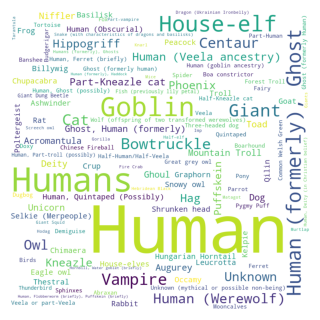

In [251]:
# Define a function to generate wordcloud
def generate_freq_wordcloud(data):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10)
    wordcloud.generate_from_frequencies(frequencies = data)
    plt.figure(figsize = (3,3), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

generate_freq_wordcloud(species_freq)

Text(0, 0.5, 'Count')

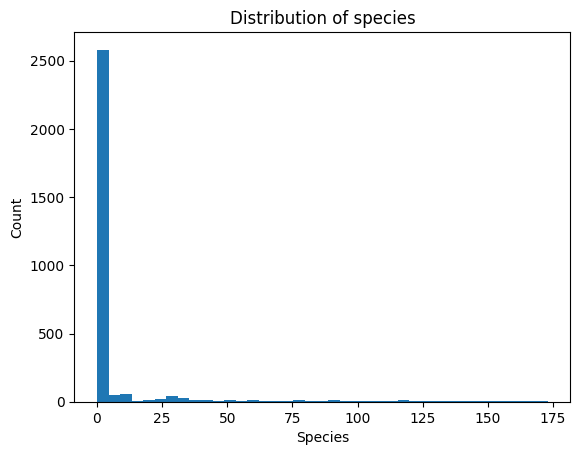

In [217]:
# Plotting distribution
bins = np.linspace(min(species_int), max(species_int), 40)
hist, edges = np.histogram(species_int, bins=bins)
x = (edges[1:]+edges[:-1])/2
width = bins[1]-bins[0]
fig, ax = plt.subplots()
ax.bar(x, hist, width)
ax.set_title('Distribution of species')
ax.set_xlabel('Species')
ax.set_ylabel('Count')
# Very heavy tailed therefore log transforming

Text(0.5, 1.0, 'Distribution of species in log space')

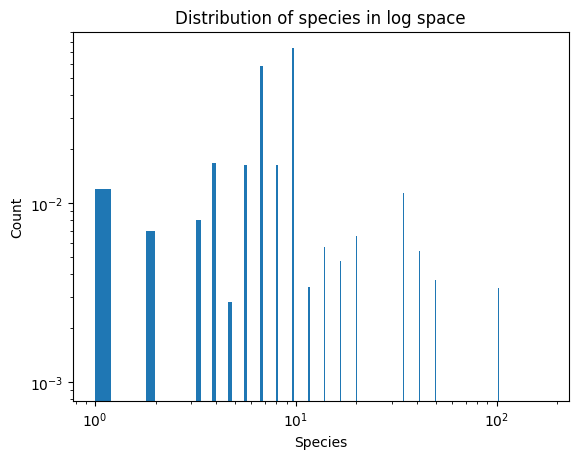

In [218]:
# Plotting species distribution in log space
bins = np.logspace(0, np.log10(192), 30)
hist, edges = np.histogram(species_int, bins=bins, density=True)
x = (edges[1:]+edges[:-1])/2
#xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
fig, ax = plt.subplots()
ax.bar(x, hist, width)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Species')
ax.set_ylabel('Count')
ax.set_title('Distribution of species in log space')